In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot  as plt
from matplotlib.pyplot import imshow,imread
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

,ID,Male,Boneage,Zscore
0,1377.png,0,180,1.279181
1,1378.png,0,12,-2.800269
2,1379.png,0,94,-0.809109
3,1380.png,1,120,-0.177766
4,1381.png,0,82,-1.100498
...,...,...,...,...
12606,15605.png,0,50,-1.877537
12607,15606.png,0,113,-0.347743
12608,15608.png,0,55,-1.756124
12609,15609.png,1,150,0.550708


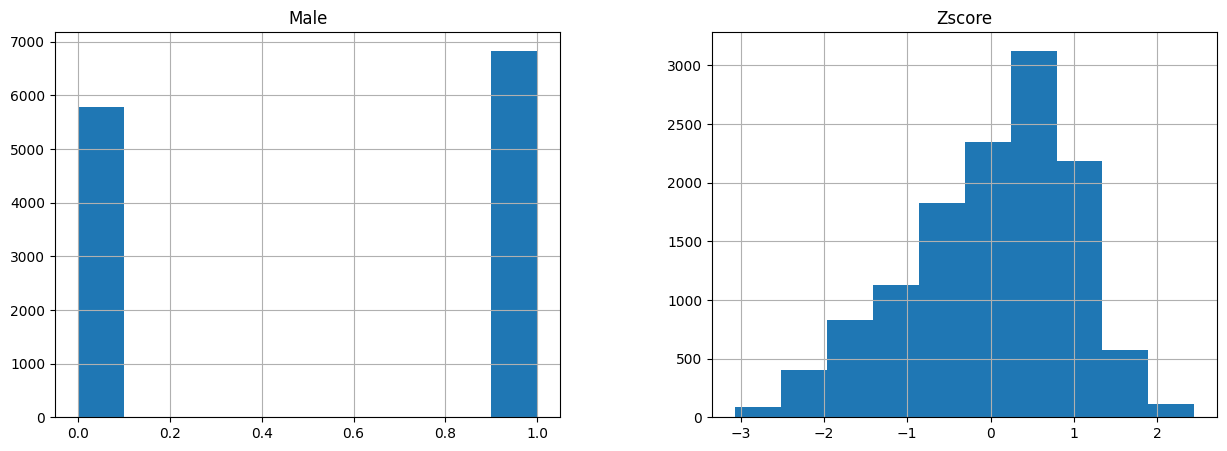

In [3]:
data_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_train.csv')
data_df ['ID'] = data_df['ID'].map(lambda x: f'{x}.png')
data_df['Male']= data_df['Male'].map(lambda x: 1 if (x == True) else 0)
mean = data_df['Boneage'].mean()
stdd = data_df['Boneage'].std()
data_df['Zscore']= data_df['Boneage'].map(lambda x:(x-mean)/stdd)
data_df[['Male','Zscore']].hist(figsize=(15,5))
data_df

In [4]:
test_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/gender_test.csv')
test_df['ID'] = test_df['ID'].map(lambda x: f'{x}.png')

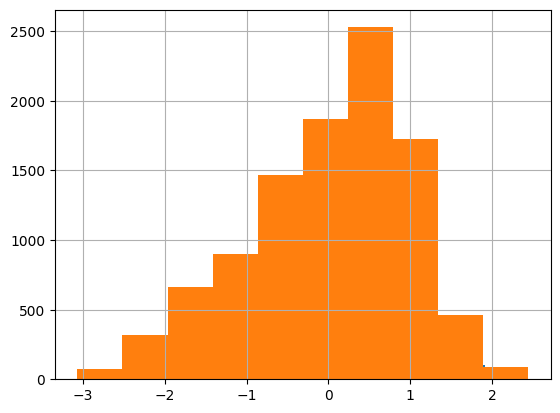

In [5]:
train_df = data_df.sample(frac=0.2)
valid_df = data_df.drop(train_df.index)


ax = [train_df['Zscore'].hist() ,valid_df['Zscore'].hist()]

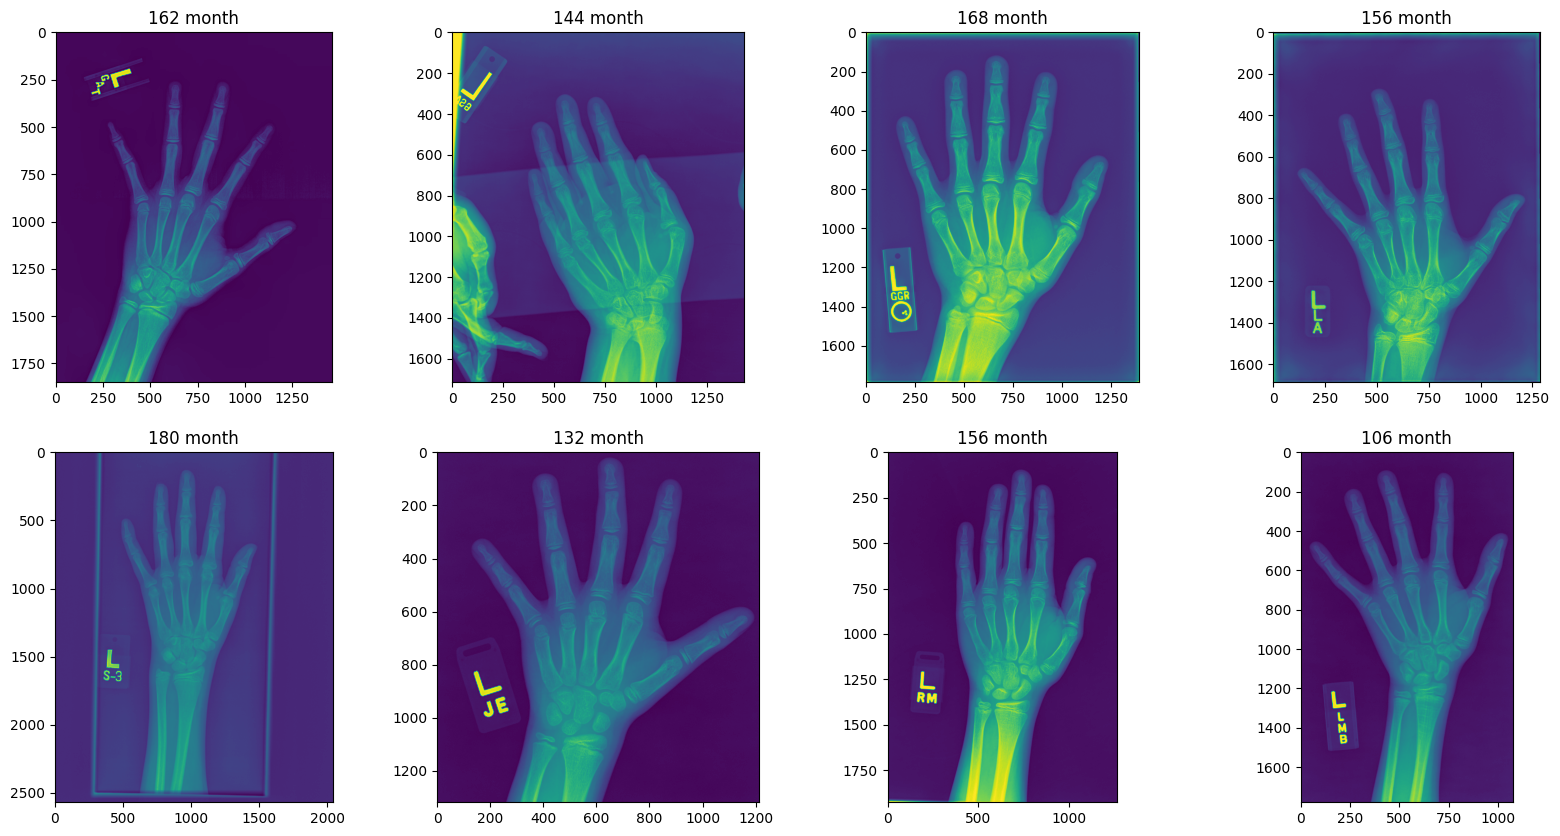

In [6]:
train_dir='dataset/RSNA_train/images'
test_dir= 'dataset/RSNA_test/images'
sample = data_df.sample(n=8)
fig,axx = plt.subplots(2,4, figsize=(20,10))
for idd,boneage,place in zip(sample['ID'],sample['Boneage'],axx.flatten()):
    place.imshow(imread(f"{train_dir}/{idd}"))
    place.set_title(str(boneage)+' month')

In [7]:
core_dg = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.1,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    dtype=None,
    preprocessing_function = tf.keras.applications.xception.preprocess_input
)

In [8]:
train_dg = core_dg.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="ID",
    y_col="Boneage",
    weight_col=None,
    target_size=(128, 128),
    color_mode="rgb",
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 2522 validated image filenames.


In [9]:
valid_dg = core_dg.flow_from_dataframe(
    valid_df,
    directory=train_dir,
    x_col="ID",
    y_col="Boneage",
    weight_col=None,
    target_size=(128, 128),
    color_mode="rgb",
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 10089 validated image filenames.


In [10]:
test_dg_core = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)
test_dg = test_dg_core.flow_from_dataframe(test_df,
                                          x_col='ID',
                                          directory = test_dir,
                                          class_mode = None)

Found 200 validated image filenames.


In [11]:
from keras import Sequential
from keras.layers import Dense,MaxPooling2D,Input,Conv2D,Dropout,BatchNormalization,GlobalMaxPooling2D,Flatten
from keras.applications.xception import Xception
from keras.metrics import MeanAbsoluteError
from keras.models import Model

In [12]:
input_shape=(128,128,3)
dropout_rate = 0.35

model_base = Xception(include_top = False,input_shape=input_shape)
model_base.trainable = True
model = Sequential()
model.add(model_base)
model.add(GlobalMaxPooling2D())
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mse', optimizer= 'adam', metrics=[MeanAbsoluteError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20,881,981
Trainable params: 20,827,453
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
model.fit_generator(train_dg, epochs = 10)

In [ ]:
model.save(filepath='checkpoint_xce.h5')

In [13]:
model.load_weights('checkpoint_xce.h5')

In [14]:
i,j = valid_dg.next()
print(i.shape)
print(j.shape)

(32, 128, 128, 3)
(32,)


In [15]:
pred = model.predict(i)


1/1 [==============================] - 39s 39s/step


In [17]:
for i in range(len(j)):
    print(f"pred:{round(pred[i][0])}\ntrue:{j[i]}\ndiff:{round(abs(pred[i][0]-j[i]))}")
    print("-"*30)

pred:182
true:168
diff:14
------------------------------
pred:175
true:148
diff:27
------------------------------
pred:146
true:156
diff:10
------------------------------
pred:230
true:192
diff:38
------------------------------
pred:165
true:156
diff:9
------------------------------
pred:139
true:132
diff:7
------------------------------
pred:179
true:180
diff:1
------------------------------
pred:173
true:162
diff:11
------------------------------
pred:156
true:126
diff:30
------------------------------
pred:156
true:186
diff:30
------------------------------
pred:128
true:138
diff:10
------------------------------
pred:169
true:132
diff:37
------------------------------
pred:119
true:50
diff:69
------------------------------
pred:159
true:150
diff:9
------------------------------
pred:76
true:60
diff:16
------------------------------
pred:166
true:159
diff:7
------------------------------
pred:200
true:204
diff:4
------------------------------
pred:170
true:132
diff:38
--------------